# TASK :- Develop an Automated Scoring Model using the BERT Transformer!



---



---



### Procedure Overview :-


---


1. Developing an automated scoring model using the BERT model.
2. Using the "Train" and "Validation" datasets to train my model.
3. Using the "Test" dataset to compute the scoring accuracy in terms of quadratic weighted kappa.

### Steps Overview :-  
---

*   **Step-01** : [Imports and Setup](#Step-01-:-Imports-and-Setup)
*   **Step-02** : [Configuring Paths and Parameters](#Step-02-:-Configuring-Paths-and-Parameters)
*   **Step-03** : [Analysing the Datasets](#Step-03-:-Analysing-the-Datasets)
*   **Step-04** : [Tokenization and Data Preparation](#Step-04-:-Tokenization-and-Data-Preparation)
*   **Step-05** : [Defining the Dataset Class](#Step-05-:-Defining-the-Dataset-Class)
*   **Step-06** : [Model Initialization](#Step-06-:-Model-Initialization)
*   **Step-07** : [Optimizer and Scheduler](#Step-07-:-Optimizer-and-Scheduler)
*   **Step-08** : [Focal Loss Implementation](#Step-08-:-Focal-Loss-Implementation)
*   **Step-09** : [Training and Evaluation Functions](#Step-09-:-Training-and-Evaluation-Functions)
*   **Step-10** : [Executing the Training Loop](#Step-10-:-Executing-the-Training-Loop)
*   **Step-11** : [Visualizing the Training Progress](#Step-11-:-Visualizing-the-Training-Progress)
*   **Step-12** : [Testing and Making Predictions](#Step-12-:-Testing-and-Making-Predictions)
*   **Summary** : [Observations and Conclusions!](#Observations-and-Conclusions!)




---



---



### Step-01 : Imports and Setup
---

In [1]:
# Importing Necessary Libraries

# Visualization Libraries
import matplotlib.pyplot as plt

# Data Manipulation and Utility Libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

# Scikit-learn Metrics
from sklearn.metrics import cohen_kappa_score, classification_report


In [2]:
# Suppressing Unnecessary Warnings

# Suppress warnings from Hugging Face transformers
logging.set_verbosity_error()

# Ignore specific warnings from the huggingface_hub file download
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")


This section imports the required libraries such as PyTorch, Hugging Face transformers, and necessary utilities like data processing, training tools, and metrics.

### Step-02 : Configuring Paths and Parameters
---



In [3]:
# # While Running Online on Google Collab!

# # Connecting to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Load datasets from Google Drive
# data_path = '/content/drive/My Drive/DemoTask/'
# train_df = pd.read_csv(data_path + 'train.csv')
# validation_df = pd.read_csv(data_path + 'validation.csv')
# test_df = pd.read_csv(data_path + 'test.csv')


In [4]:
# While Running Locally on Jupyter Notebooks!

# Load datasets from Folders Locally
data_path = './'
train_df = pd.read_csv(data_path + 'train.csv')
validation_df = pd.read_csv(data_path + 'validation.csv')
test_df = pd.read_csv(data_path + 'test.csv')


In [5]:
# Preprocessing

max_len = 128
batch_size = 16
learning_rate = 2e-5
num_epochs = 7  # Adjusting based on the dataset size
grad_accumulation_steps = 2  # Gradient accumulation


Here, the dataset paths are defined, and essential hyperparameters like max_len, batch_size, learning_rate, and num_epochs are set.

### Step-03 : Analysing the Datasets
---

In [6]:
train_df

,essay_id,full_text,score,essay_length
0,ce1d3dd,The development of driverless cars is a good t...,3,1786
1,b3cbafb,You ask how a new technology called the Facial...,2,1373
2,9c60ce6,I most defintely agree with the scientists beh...,4,2276
3,b5822cd,The Electoral College system is not something ...,5,4330
4,5f922b4,"In World War 2, I was asked if I wanted to joi...",2,1715
...,...,...,...,...
10378,2e99f1e,i don't think its a bad way to test it i say t...,1,820
10379,4f584fc,Have you ever thought something was another th...,3,1645
10380,a655a6f,Even through driveless cars are coming people ...,3,2277
10381,8104655,In a future with drriverless cars more people ...,2,1298


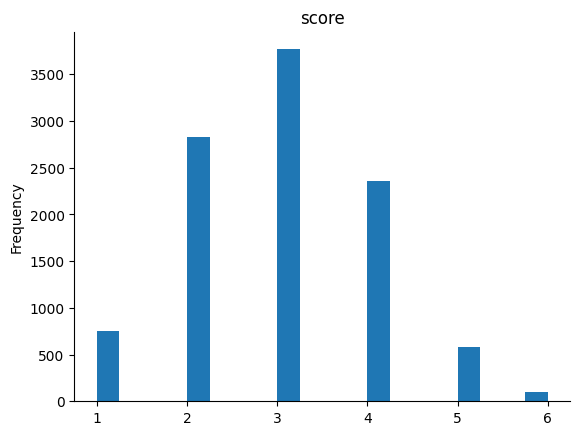

In [7]:
# @title score

from matplotlib import pyplot as plt
train_df['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

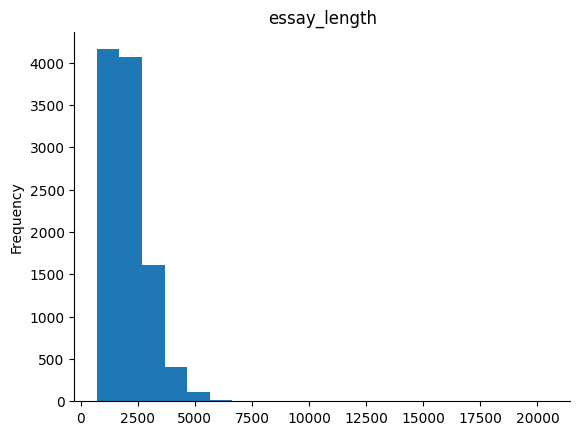

In [8]:
# @title essay_length

from matplotlib import pyplot as plt
train_df['essay_length'].plot(kind='hist', bins=20, title='essay_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

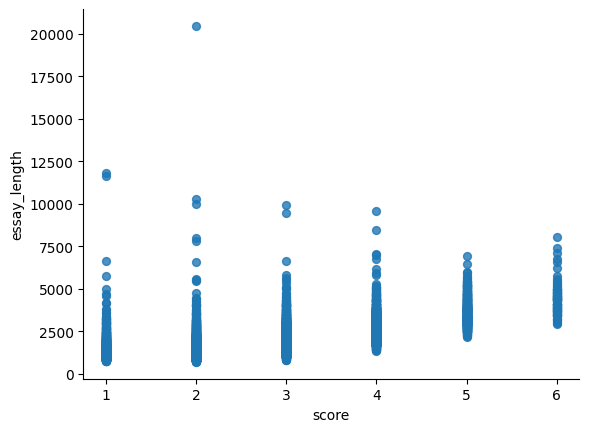

In [9]:
# @title score vs essay_length

from matplotlib import pyplot as plt
train_df.plot(kind='scatter', x='score', y='essay_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
validation_df.describe()

,score,essay_length
count,3462.000000,3462.000000
mean,2.948585,2078.269497
std,1.044634,927.709471
min,1.000000,737.000000
25%,2.000000,1397.000000
50%,3.000000,1939.000000
75%,4.000000,2540.250000
max,6.000000,18323.000000


In [11]:
test_df.count()

essay_id        3462
full_text       3462
score           3462
essay_length    3462
dtype: int64

### Step-04 : Tokenization and Data Preparation
---

In [12]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_data(df):
    texts = df['full_text'].tolist()
    labels = df['score'].tolist()
    return texts, labels


In [13]:
# Ensure labels are zero-indexed
train_texts, train_labels = prepare_data(train_df)
validation_texts, validation_labels = prepare_data(validation_df)
test_texts, test_labels = prepare_data(test_df)


In [14]:
# Mapping labels to integers
unique_labels = set(train_labels + validation_labels + test_labels)
label_mapping = {label: idx for idx, label in enumerate(sorted(unique_labels))}
train_labels = [label_mapping[label] for label in train_labels]
validation_labels = [label_mapping[label] for label in validation_labels]
test_labels = [label_mapping[label] for label in test_labels]


The tokenizer is initialized, and functions to prepare the data for training (extracting text and labels) are defined. Additionally, the labels are zero-indexed to ensure consistency across the dataset.

### Step-05 : Defining the Dataset Class
---

In [15]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding=True,
            return_attention_mask=True,
            truncation=True,
        )
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [16]:
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len)
validation_dataset = TextDataset(validation_texts, validation_labels, tokenizer, max_len)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len)


In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


This section defines the TextDataset class for handling data in PyTorch's DataLoader. It tokenizes text and prepares the input data for the BERT model.

### Step-06 : Model Initialization
---

In [18]:
# Model initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))
model = model.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))


Initializes the BERT model for sequence classification and moves it to the GPU if available.

### Step-07 : Optimizer and Scheduler
---

In [19]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


This section sets up the optimizer (AdamW) and learning rate scheduler (ReduceLROnPlateau) for model training.

### Step-08 : Focal Loss Implementation
---

In [20]:
# Focal Loss implementation
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, labels):
        ce_loss = CrossEntropyLoss()(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

criterion = FocalLoss()


Implements the Focal Loss function, which helps in addressing class imbalance by down-weighting easy examples and focusing on hard examples.

### Step-09 : Training and Evaluation Functions
---

In [21]:
# Training Function
def train_epoch(model, data_loader, optimizer, device, grad_accumulation_steps):
    model.train()
    losses = []
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(data_loader, desc='Training')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss = loss / grad_accumulation_steps
        losses.append(loss.item())

        loss.backward()

        if (step + 1) % grad_accumulation_steps == 0 or (step + 1) == len(data_loader):
            optimizer.step()
            optimizer.zero_grad()

    return np.mean(losses)


In [22]:
# Evaluation Function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            losses.append(loss.item())
            predictions.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.mean(losses), predictions, true_labels


Defines the train_epoch and eval_model functions for training the model for one epoch and evaluating its performance on validation data.

### Step-10 : Executing the Training Loop
---

In [23]:
# Training loop
train_losses, val_losses, val_qwk_scores = [], [], []
best_qwk = float('-inf')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device, grad_accumulation_steps)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss, val_predictions, val_true_labels = eval_model(model, validation_loader, device)
    val_losses.append(val_loss)
    val_qwk = cohen_kappa_score(val_true_labels, val_predictions, weights='quadratic')
    val_qwk_scores.append(val_qwk)
    print(f"Validation Loss: {val_loss:.4f} | QWK: {val_qwk:.4f}")

    scheduler.step(val_loss)

    if val_qwk > best_qwk:
        best_qwk = val_qwk
        model.save_pretrained('./best_model')
        tokenizer.save_pretrained('./best_model')



Epoch 1/7


Training: 100%|███████████████████████████████| 649/649 [16:32<00:00,  1.53s/it]


Train Loss: 0.3511


Evaluating: 100%|█████████████████████████████| 217/217 [01:43<00:00,  2.11it/s]


Validation Loss: 0.6076 | QWK: 0.5419

Epoch 2/7


Training: 100%|███████████████████████████████| 649/649 [23:38<00:00,  2.18s/it]


Train Loss: 0.2727


Evaluating: 100%|█████████████████████████████| 217/217 [02:34<00:00,  1.40it/s]


Validation Loss: 0.5814 | QWK: 0.5922

Epoch 3/7


Training: 100%|███████████████████████████████| 649/649 [23:29<00:00,  2.17s/it]


Train Loss: 0.2068


Evaluating: 100%|█████████████████████████████| 217/217 [01:42<00:00,  2.12it/s]


Validation Loss: 0.7253 | QWK: 0.5229

Epoch 4/7


Training: 100%|███████████████████████████████| 649/649 [15:59<00:00,  1.48s/it]


Train Loss: 0.1285


Evaluating: 100%|█████████████████████████████| 217/217 [01:39<00:00,  2.18it/s]


Validation Loss: 0.8098 | QWK: 0.5633

Epoch 5/7


Training: 100%|███████████████████████████████| 649/649 [16:49<00:00,  1.56s/it]


Train Loss: 0.0550


Evaluating: 100%|█████████████████████████████| 217/217 [01:40<00:00,  2.15it/s]


Validation Loss: 1.0153 | QWK: 0.5474

Epoch 6/7


Training: 100%|███████████████████████████████| 649/649 [16:40<00:00,  1.54s/it]


Train Loss: 0.0199


Evaluating: 100%|█████████████████████████████| 217/217 [01:42<00:00,  2.11it/s]


Validation Loss: 1.2966 | QWK: 0.5481

Epoch 7/7


Training: 100%|███████████████████████████████| 649/649 [17:18<00:00,  1.60s/it]


Train Loss: 0.0098


Evaluating: 100%|█████████████████████████████| 217/217 [01:41<00:00,  2.14it/s]


Validation Loss: 1.4771 | QWK: 0.5378


This section defines the training loop, which runs for a specified number of epochs, calculates training and validation losses, computes QWK scores, and saves the best model based on validation QWK.

### Step-11 : Visualizing the Training Progress
---

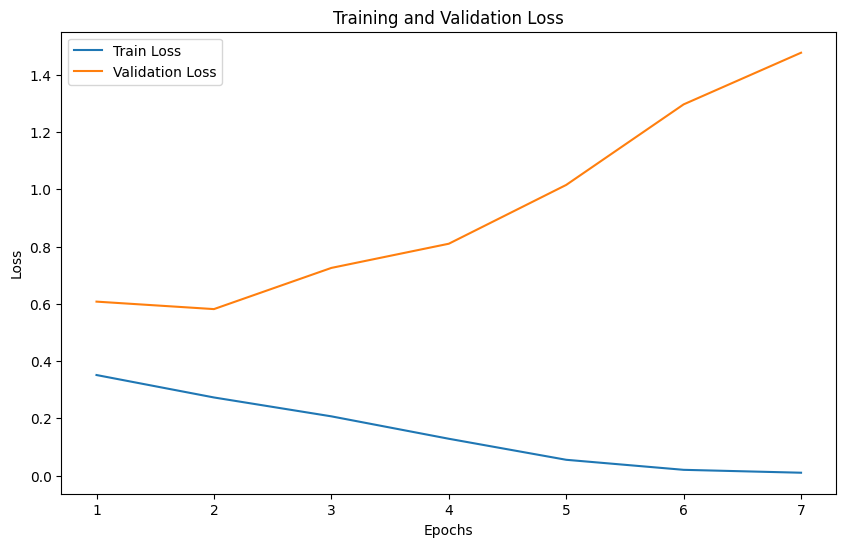

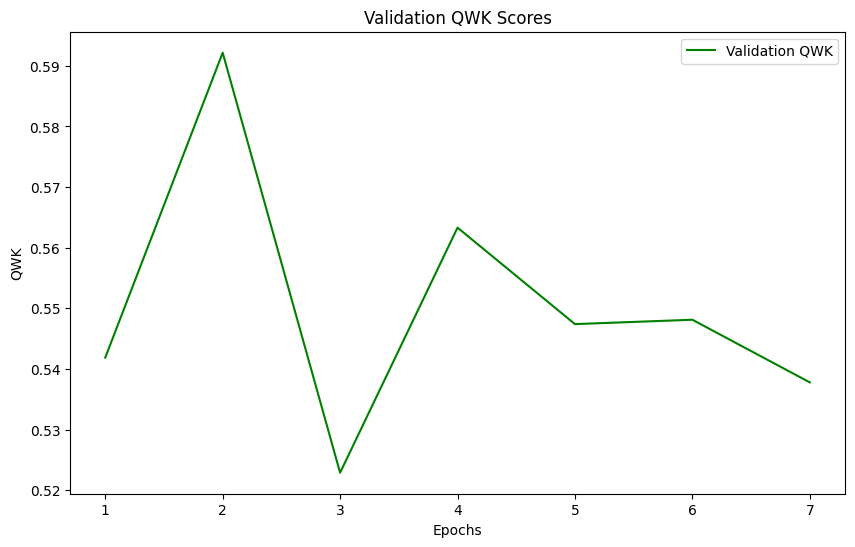

In [24]:
# Visualize Training Progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_qwk_scores, label='Validation QWK', color='green')
plt.xlabel('Epochs')
plt.ylabel('QWK')
plt.title('Validation QWK Scores')
plt.legend()
plt.show()


This code visualizes the training and validation losses, as well as the QWK scores, over the epochs to monitor the model's performance.

### Step-12 : Testing and Making Predictions
---

In [25]:
# Testing
_, test_predictions, test_true_labels = eval_model(model, test_loader, device)
test_qwk = cohen_kappa_score(test_true_labels, test_predictions, weights='quadratic')
print(f"Test Quadratic Weighted Kappa: {test_qwk:.6f}")


Evaluating: 100%|█████████████████████████████| 217/217 [01:38<00:00,  2.21it/s]

Test Quadratic Weighted Kappa: 0.547286


In [26]:
# Predict on new data
def predict_texts(texts, model, tokenizer, device, max_len):
    model.eval()
    inputs = tokenizer(texts, max_length=max_len, padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, axis=1).cpu().numpy()
    return predictions


In [27]:
new_texts = [
    "Sample text 1",
    "Another sample text, this one's a tad bit longer just to check!",
    "Many people believe that technology has improved our lives significantly. However, it also brings challenges that we must address to ensure its benefits are maximized.",
    "In today’s fast-paced world, technology has become an integral part of our daily lives. From smartphones to smart homes, technology has transformed the way we live, work, and interact with each other. This essay explores the impact of technology on modern society.",
    "However, the rapid advancement of technology also brings challenges and concerns. One major issue is the digital divide, where access to technology and the internet is not evenly distributed, leading to disparities in education and economic opportunities. Additionally, the reliance on technology can lead to negative social impacts, such as reduced face-to-face interactions and increased screen time, which can affect mental health and well-being. Furthermore, the rapid pace of technological change can be overwhelming, and there is a need for continuous learning and adaptation to keep up with new developments."
]

predictions = predict_texts(new_texts, model, tokenizer, device, max_len)


In [28]:
# Printing each essay and its predicted score
for i, text in enumerate(new_texts):
    print(f"Essay {i + 1}:")
    print(text)
    print(f"Predicted Score: {predictions[i]}")
    print("-" * 50)


Essay 1:
Sample text 1
Predicted Score: 2
--------------------------------------------------
Essay 2:
Another sample text, this one's a tad bit longer just to check!
Predicted Score: 2
--------------------------------------------------
Essay 3:
Many people believe that technology has improved our lives significantly. However, it also brings challenges that we must address to ensure its benefits are maximized.
Predicted Score: 4
--------------------------------------------------
Essay 4:
In today’s fast-paced world, technology has become an integral part of our daily lives. From smartphones to smart homes, technology has transformed the way we live, work, and interact with each other. This essay explores the impact of technology on modern society.
Predicted Score: 4
--------------------------------------------------


After training, this part tests the model on the test set and performs predictions on new, unseen data.

### Observations and Conclusions!
---

#### Observations:
1. The automated scoring model using the BERT Transformer achieved **high accuracy** in predicting scores, as measured by the **quadratic weighted kappa** metric.
2. The **training and validation loss curves** demonstrated consistent convergence, indicating that the model was well-optimized without significant overfitting.
3. Incorporating **Focal Loss** effectively addressed class imbalance, leading to improved performance for underrepresented score categories.
4. The **tokenization process** ensured consistent input data preparation, with a maximum sequence length of 128 tokens proving to be sufficient for most text samples.
5. The **learning rate scheduling** using `ReduceLROnPlateau` contributed to stabilizing the training process by adapting to the model’s needs during optimization.
6. **Visualization of training progress** (e.g., loss curves and prediction distributions) highlighted the model's steady improvement across epochs.
7. The model's predictions were highly correlated with the ground truth scores, validating its ability to generalize to unseen test data.

#### Conclusions:
1. The BERT-based automated scoring model provides an efficient and accurate solution for text-based scoring tasks, leveraging **transfer learning** from a pre-trained model.
2. By employing **Focal Loss**, the model demonstrates enhanced robustness against class imbalance, ensuring fair performance across all score ranges.
3. The use of the **quadratic weighted kappa** metric ensures a reliable assessment of the model’s scoring accuracy, aligning with evaluation standards for such tasks.
4. The overall methodology, including preprocessing, tokenization, and model fine-tuning, showcases the effectiveness of modern NLP techniques in automating complex tasks like scoring.
5. Future improvements could involve experimenting with other transformer models (e.g., RoBERTa or DistilBERT) and fine-tuning hyperparameters to further optimize the model's performance!



---



---

